## 2.1 Data Loading and Preprocessing

In [ ]:
import os
import zipfile
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt




def unzip_data(zip_path, extract_to):
    """Unzip the dataset if it exists."""
    if not os.path.exists(extract_to):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

# Unzip the dataset
zip_file_path = "double_mnist.zip"
extracted_folder = "double_mnist"
unzip_data(zip_file_path, extracted_folder)



# Image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

def load_mnist_data(data_dir):
    train_data, train_labels = [], []
    val_data, val_labels = [], []
    test_data, test_labels = [], []

    for split in ["train", "val", "test"]:
        split_path = os.path.join(data_dir, split)
        for label_folder in os.listdir(split_path):
            label_path = os.path.join(split_path, label_folder)

            
            if label_folder == '0':
                digit_count = 0
            else:
                digit_count = len(label_folder) 

            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = Image.open(img_path)
                img_tensor = transform(img)

                if split == "train":
                    train_data.append(img_tensor)
                    train_labels.append(digit_count)
                elif split == "val":
                    val_data.append(img_tensor)
                    val_labels.append(digit_count)
                elif split == "test":
                    test_data.append(img_tensor)
                    test_labels.append(digit_count)

    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, torch.tensor(label, dtype=torch.long)

# Load data from the dataset
data_dir = "double_mnist/double_mnist" 
train_data, val_data, test_data = load_mnist_data(data_dir)

train_loader = DataLoader(MultiMNISTDataset(*train_data), batch_size=64, shuffle=True)
val_loader = DataLoader(MultiMNISTDataset(*val_data), batch_size=64, shuffle=False)
test_loader = DataLoader(MultiMNISTDataset(*test_data), batch_size=64, shuffle=False)


##  2.2 Implement the CNN Class

In [ ]:
class MultiMNISTCNN(nn.Module):
    def __init__(self, task="classification", dropout_rate=0.0):
        super(MultiMNISTCNN, self).__init__()
        self.task = task
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 3 * 3, 64)
        self.dropout = nn.Dropout(dropout_rate)

        if self.task == "classification":
            self.fc2 = nn.Linear(64, 4)  
        elif self.task == "regression":
            self.fc2 = nn.Linear(64, 1) 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

       
        if self.task == "classification":
            x = F.log_softmax(self.fc2(x), dim=1) 
        else:
            x = self.fc2(x)

        return x

Epoch [1/10], Train Loss: 0.4632, Val Loss: 0.0061
Epoch [2/10], Train Loss: 0.0081, Val Loss: 0.0095
Epoch [3/10], Train Loss: 0.0017, Val Loss: 0.0009
Epoch [4/10], Train Loss: 0.0004, Val Loss: 0.0005
Epoch [5/10], Train Loss: 0.0001, Val Loss: 0.0005
Epoch [6/10], Train Loss: 0.0001, Val Loss: 0.0004
Epoch [7/10], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [8/10], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [9/10], Train Loss: 0.0000, Val Loss: 0.0004
Epoch [10/10], Train Loss: 0.0000, Val Loss: 0.0003
Test Accuracy: 1.0000
Epoch [1/10], Train Loss: 0.3624, Val Loss: 0.0863
Epoch [2/10], Train Loss: 0.0257, Val Loss: 0.0144
Epoch [3/10], Train Loss: 0.0106, Val Loss: 0.0063
Epoch [4/10], Train Loss: 0.0073, Val Loss: 0.0043
Epoch [5/10], Train Loss: 0.0060, Val Loss: 0.0072
Epoch [6/10], Train Loss: 0.0077, Val Loss: 0.0178
Epoch [7/10], Train Loss: 0.0038, Val Loss: 0.0064
Epoch [8/10], Train Loss: 0.0042, Val Loss: 0.0071
Epoch [9/10], Train Loss: 0.0033, Val Loss: 0.0037
Epoch [1

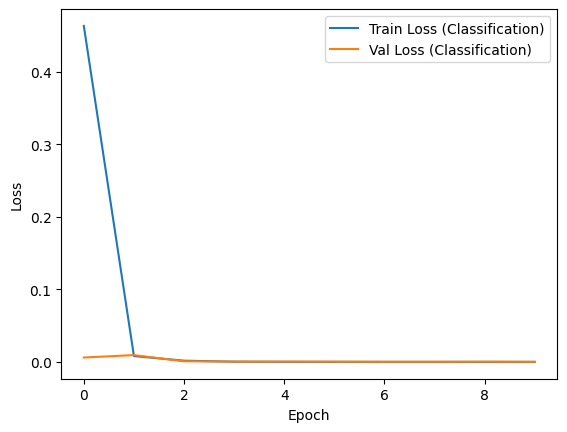

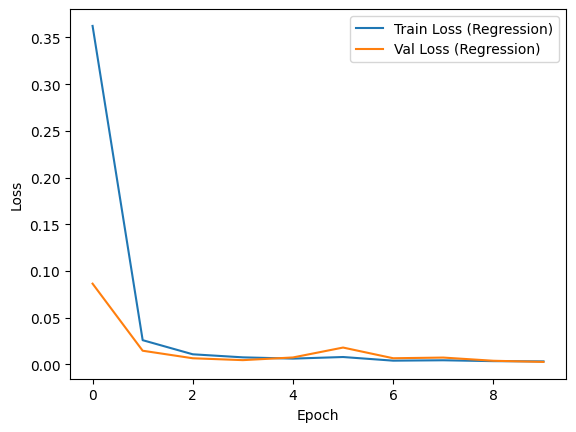

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)

            if model.task == "classification":
                loss = criterion(outputs, labels)
            else: 
                loss = criterion(outputs, labels.float().unsqueeze(1))

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)

               
                if model.task == "classification":
                    loss = criterion(outputs, labels)
                else: 
                    loss = criterion(outputs, labels.float().unsqueeze(1))

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)

            if model.task == "classification":
                _, predicted = torch.max(outputs, 1) 
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            else: 
                predicted = outputs.squeeze() 
                rounded_predictions = torch.round(predicted).long() 
                total += labels.size(0)
                correct += (rounded_predictions == labels).sum().item() 

    if model.task == "classification":
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.4f}")
    else:  
        accuracy = correct / total 
        print(f"Test Accuracy (Rounded Predictions): {accuracy:.4f}")

    return accuracy


lr = 0.001

# For classification task
model_classification = MultiMNISTCNN(task="classification")
criterion_classification = nn.NLLLoss()  # For classification
optimizer_classification = optim.Adam(model_classification.parameters(), lr=lr)

train_losses_class, val_losses_class = train_model(model_classification, train_loader, val_loader, criterion_classification, optimizer_classification, epochs=10)
_ = evaluate_model(model_classification, test_loader)

# For regression task
model_regression = MultiMNISTCNN(task="regression")
criterion_regression = nn.MSELoss()  # For regression
optimizer_regression = optim.Adam(model_regression.parameters(), lr=lr)

train_losses_reg, val_losses_reg = train_model(model_regression, train_loader, val_loader, criterion_regression, optimizer_regression, epochs=10)
_ = evaluate_model(model_regression, test_loader)

# Plotting training and validation loss for classification
plt.plot(train_losses_class, label="Train Loss (Classification)")
plt.plot(val_losses_class, label="Val Loss (Classification)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting training and validation loss for regression
plt.plot(train_losses_reg, label="Train Loss (Regression)")
plt.plot(val_losses_reg, label="Val Loss (Regression)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 2.3 Hyperparameter Tuning

In [ ]:
hyperparams_combinations_classification = [
    (0.001, 0.0, 'SGD'),
    (0.0001, 0.2, 'Adam'),
    (0.01, 0.5, 'Adam'),
    (0.001, 0, 'Adam'),
    (0.0001, 0, 'SGD'),
]

all_train_losses_class = []
all_val_losses_class = []

hyperparams_combinations_regression = [
    (0.001, 0.0, 'SGD'),
    (0.0001, 0.2, 'Adam'),
    (0.01, 0.5, 'Adam'),
    (0.001, 0, 'Adam'),
    (0.0001, 0, 'SGD'),
]

all_train_losses_reg = []
all_val_losses_reg = []

for lr, dropout_rate, optimizer_name in hyperparams_combinations_classification:
    model_classification = MultiMNISTCNN(task="classification", dropout_rate=dropout_rate)
    criterion_classification = nn.NLLLoss()
    optimizer_classification = getattr(optim, optimizer_name)(model_classification.parameters(), lr=lr)

    train_losses_class, val_losses_class = train_model(model_classification, train_loader, val_loader, criterion_classification, optimizer_classification, epochs=10)
    _ = evaluate_model(model_classification, test_loader)
    all_train_losses_class.append(train_losses_class)
    all_val_losses_class.append(val_losses_class)

    # For regression task
for lr, dropout_rate, optimizer_name in hyperparams_combinations_regression:
    model_regression = MultiMNISTCNN(task="regression", dropout_rate=dropout_rate)
    criterion_regression = nn.MSELoss()  # For regression
    optimizer_regression = getattr(optim, optimizer_name)(model_regression.parameters(), lr=lr)

    train_losses_reg, val_losses_reg = train_model(model_regression, train_loader, val_loader, criterion_regression, optimizer_regression, epochs=10)
    _ = evaluate_model(model_regression, test_loader)
    all_train_losses_reg.append(train_losses_reg)
    all_val_losses_reg.append(val_losses_reg)

# plt.figure(figsize=(12, 6))
# for i, (train_losses, val_losses) in enumerate(zip(all_train_losses_class, all_val_losses_class)):
#     label = f"Train Loss (LR={hyperparams_combinations_classification[i][0]}, Dropout={hyperparams_combinations_classification[i][1]}, Optimizer={hyperparams_combinations_classification[i][3]})"
#     plt.plot(train_losses, label=label)

#     label_val = f"Val Loss (LR={hyperparams_combinations_classification[i][0]}, Dropout={hyperparams_combinations_classification[i][1]}, Optimizer={hyperparams_combinations_classification[i][3]})"
#     plt.plot(val_losses, label=label_val)

# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Classification: Training and Validation Losses")
# plt.legend()
# plt.show()

# plt.figure(figsize=(12, 6))
# for i, (train_losses, val_losses) in enumerate(zip(all_train_losses_reg, all_val_losses_reg)):
#     label = f"Train Loss (LR={hyperparams_combinations_regression[i][0]}, Dropout={hyperparams_combinations_regression[i][1]}, Optimizer={hyperparams_combinations_regression[i][3]})"
#     plt.plot(train_losses, label=label)

#     label_val = f"Val Loss (LR={hyperparams_combinations_regression[i][0]}, Dropout={hyperparams_combinations_regression[i][1]}, Optimizer={hyperparams_combinations_regression[i][3]})"
#     plt.plot(val_losses, label=label_val)

# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Regression: Training and Validation Losses")
# plt.legend()
# plt.show()



Epoch [1/10], Train Loss: 1.3626, Val Loss: 1.3303
Epoch [2/10], Train Loss: 1.2927, Val Loss: 1.2442
Epoch [3/10], Train Loss: 1.1892, Val Loss: 1.1181
Epoch [4/10], Train Loss: 1.0949, Val Loss: 1.0516
Epoch [5/10], Train Loss: 1.0600, Val Loss: 1.0314
Epoch [6/10], Train Loss: 1.0473, Val Loss: 1.0235
Epoch [7/10], Train Loss: 1.0418, Val Loss: 1.0195
Epoch [8/10], Train Loss: 1.0385, Val Loss: 1.0210
Epoch [9/10], Train Loss: 1.0374, Val Loss: 1.0171
Epoch [10/10], Train Loss: 1.0362, Val Loss: 1.0189
Test Accuracy: 0.4348
Epoch [1/10], Train Loss: 1.0966, Val Loss: 0.9760
Epoch [2/10], Train Loss: 0.6446, Val Loss: 0.1801
Epoch [3/10], Train Loss: 0.1656, Val Loss: 0.0553
Epoch [4/10], Train Loss: 0.0847, Val Loss: 0.0412
Epoch [5/10], Train Loss: 0.0578, Val Loss: 0.0215
Epoch [6/10], Train Loss: 0.0409, Val Loss: 0.0146
Epoch [7/10], Train Loss: 0.0286, Val Loss: 0.0067
Epoch [8/10], Train Loss: 0.0227, Val Loss: 0.0054
Epoch [9/10], Train Loss: 0.0178, Val Loss: 0.0050
Epoch [1

IndexError: tuple index out of range

<Figure size 1200x600 with 0 Axes>

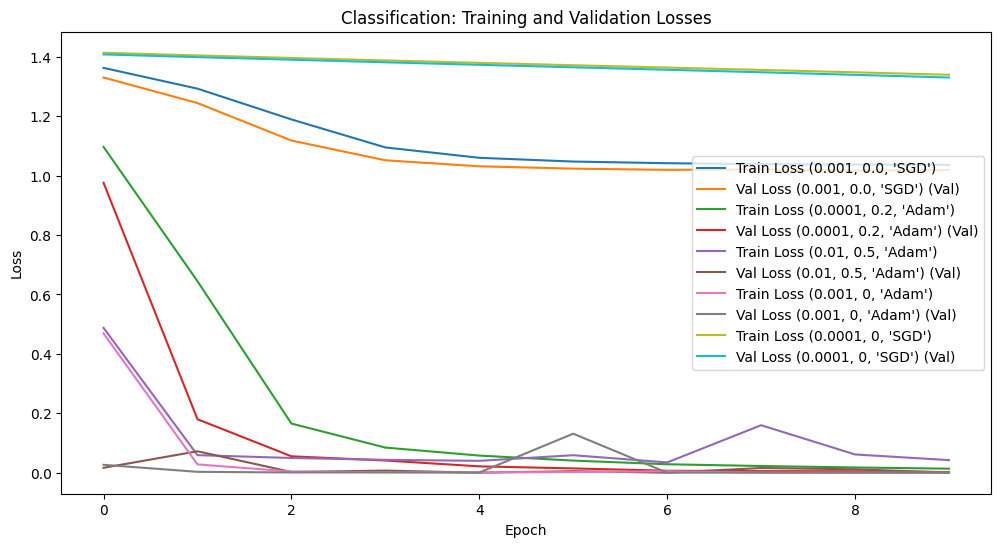

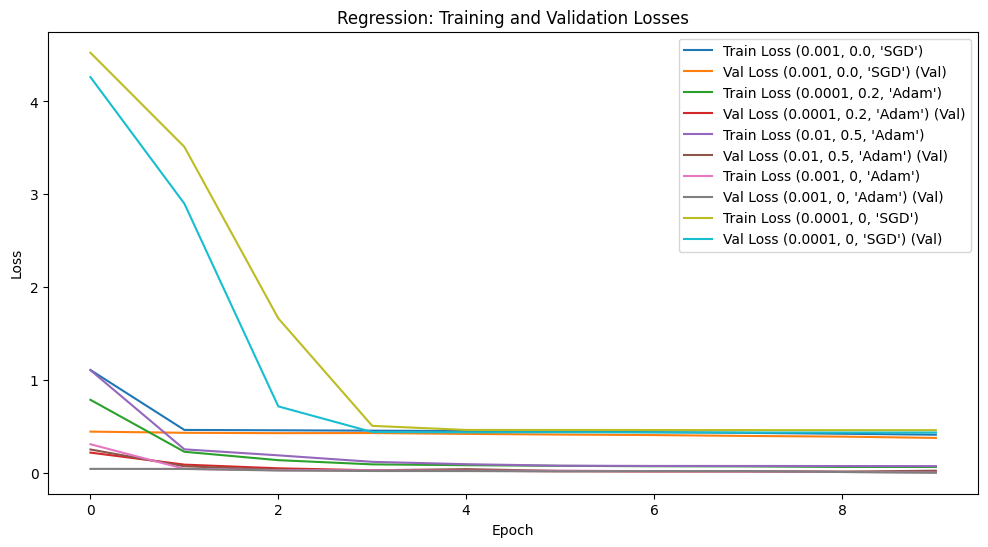

In [ ]:
plt.figure(figsize=(12, 6))
for i, (train_losses, val_losses) in enumerate(zip(all_train_losses_class, all_val_losses_class)):
    plt.plot(train_losses, label=f"Train Loss {hyperparams_combinations_classification[i]}")
    plt.plot(val_losses, label=f"Val Loss {hyperparams_combinations_classification[i]} (Val)")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classification: Training and Validation Losses")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for i, (train_losses, val_losses) in enumerate(zip(all_train_losses_reg, all_val_losses_reg)):
    plt.plot(train_losses, label=f"Train Loss {hyperparams_combinations_regression[i]}")
    plt.plot(val_losses, label=f"Val Loss {hyperparams_combinations_regression[i]} (Val)")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Regression: Training and Validation Losses")
plt.legend()
plt.show()

#### Best Model : Adam Optimizer, lr = 0.001, dropout = 0.

Epoch [1/10], Train Loss: 0.6053, Val Loss: 0.0884
Epoch [2/10], Train Loss: 0.0567, Val Loss: 0.0813
Epoch [3/10], Train Loss: 0.0145, Val Loss: 0.0083
Epoch [4/10], Train Loss: 0.0094, Val Loss: 0.0057
Epoch [5/10], Train Loss: 0.0052, Val Loss: 0.0011
Epoch [6/10], Train Loss: 0.0009, Val Loss: 0.0048
Epoch [7/10], Train Loss: 0.0005, Val Loss: 0.0004
Epoch [8/10], Train Loss: 0.0003, Val Loss: 0.0004
Epoch [9/10], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [10/10], Train Loss: 0.0001, Val Loss: 0.0002
Test Accuracy: 1.0000
Epoch [1/10], Train Loss: 0.3258, Val Loss: 0.0298
Epoch [2/10], Train Loss: 0.0208, Val Loss: 0.0092
Epoch [3/10], Train Loss: 0.0138, Val Loss: 0.0080
Epoch [4/10], Train Loss: 0.0080, Val Loss: 0.0046
Epoch [5/10], Train Loss: 0.0045, Val Loss: 0.0042
Epoch [6/10], Train Loss: 0.0040, Val Loss: 0.0046
Epoch [7/10], Train Loss: 0.0042, Val Loss: 0.0030
Epoch [8/10], Train Loss: 0.0039, Val Loss: 0.0030
Epoch [9/10], Train Loss: 0.0028, Val Loss: 0.0032
Epoch [1

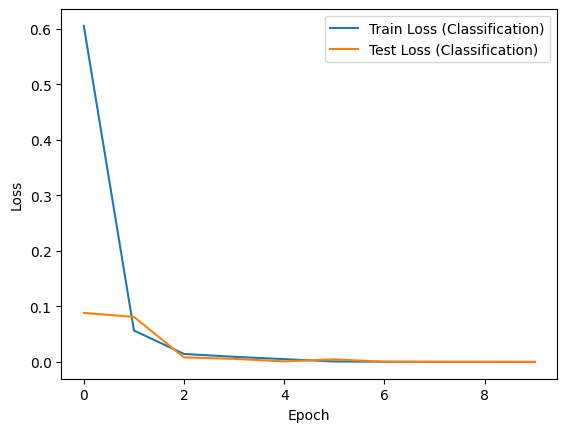

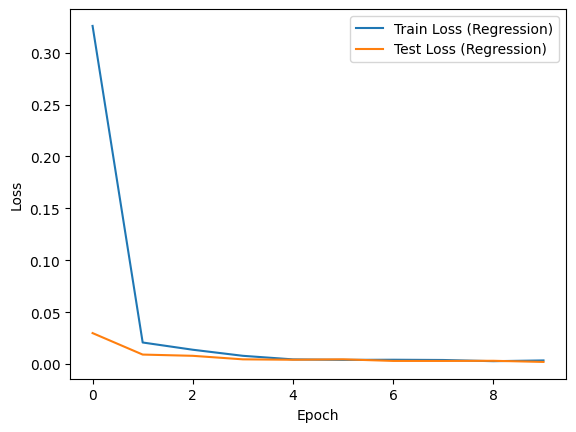

In [ ]:
# on test set


lr = 0.001

# For classification task
model_classification = MultiMNISTCNN(task="classification")
criterion_classification = nn.NLLLoss() 
optimizer_classification = optim.Adam(model_classification.parameters(), lr=lr)

train_losses_class, val_losses_class = train_model(model_classification, train_loader, test_loader, criterion_classification, optimizer_classification, epochs=10)
_ = evaluate_model(model_classification, test_loader)

# For regression task
model_regression = MultiMNISTCNN(task="regression")
criterion_regression = nn.MSELoss()
optimizer_regression = optim.Adam(model_regression.parameters(), lr=lr)

train_losses_reg, val_losses_reg = train_model(model_regression, train_loader, test_loader, criterion_regression, optimizer_regression, epochs=10)
_ = evaluate_model(model_regression, test_loader)

# Plotting training and validation loss for classification
plt.plot(train_losses_class, label="Train Loss (Classification)")
plt.plot(val_losses_class, label="Test Loss (Classification)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting training and validation loss for regression
plt.plot(train_losses_reg, label="Train Loss (Regression)")
plt.plot(val_losses_reg, label="Test Loss (Regression)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

##  2.4 Feature map Visualization

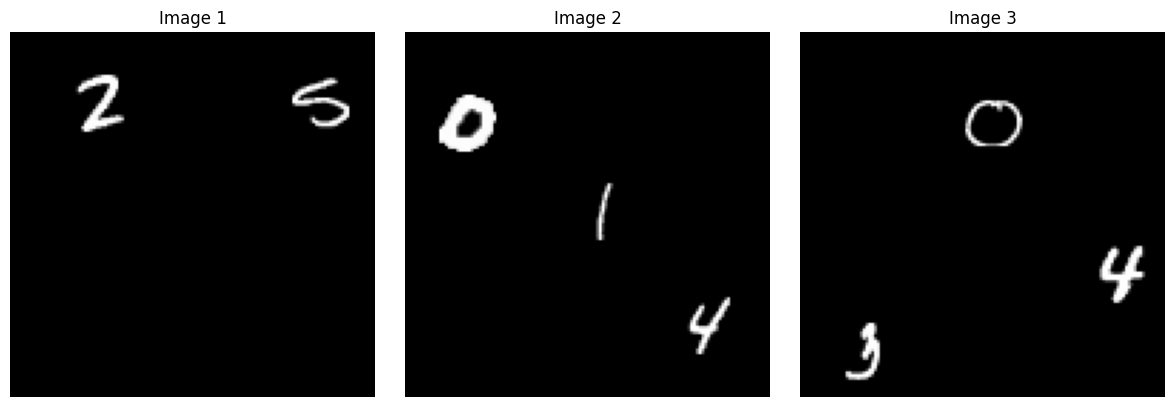

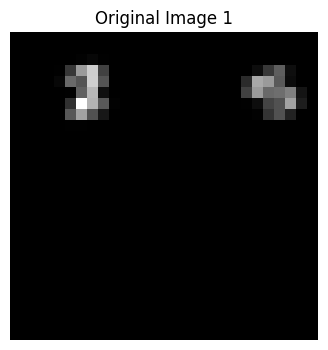

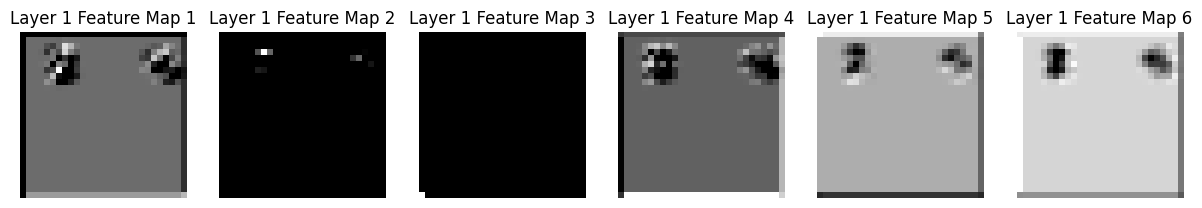

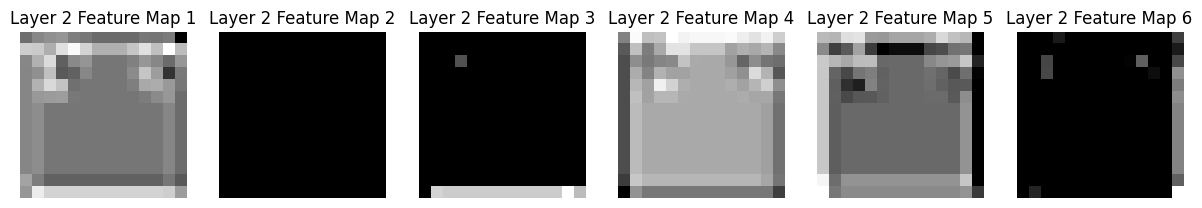

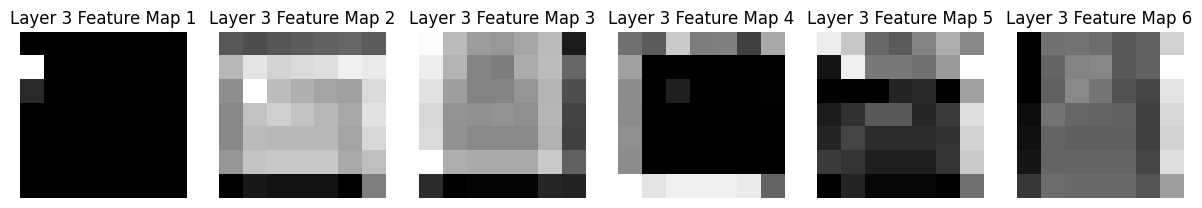

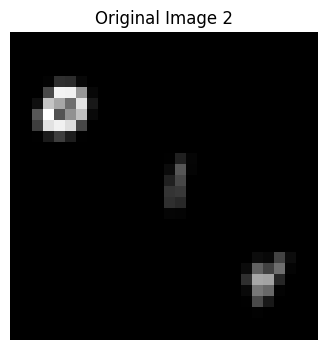

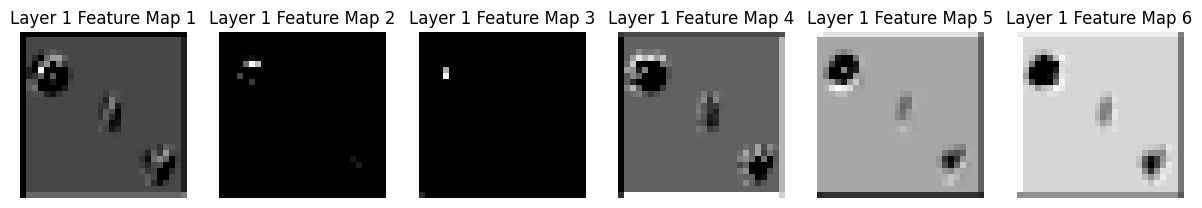

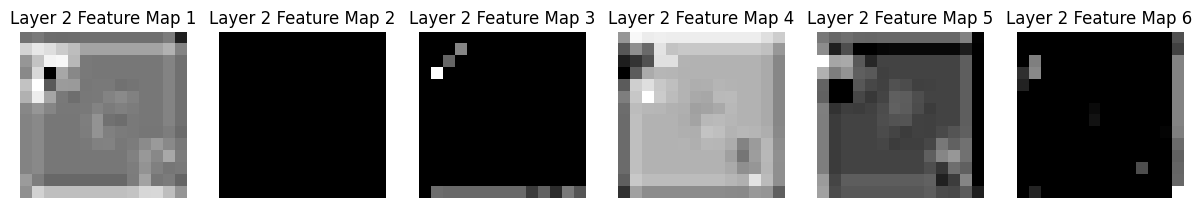

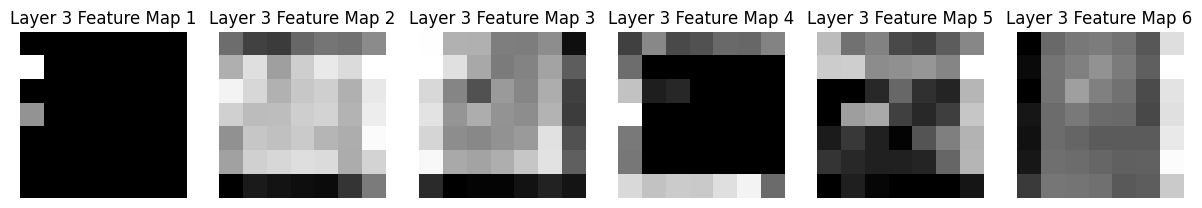

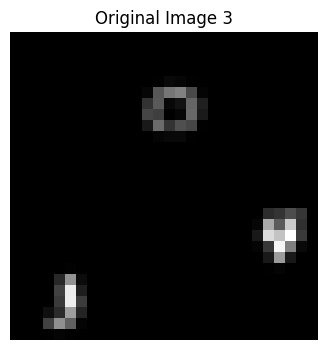

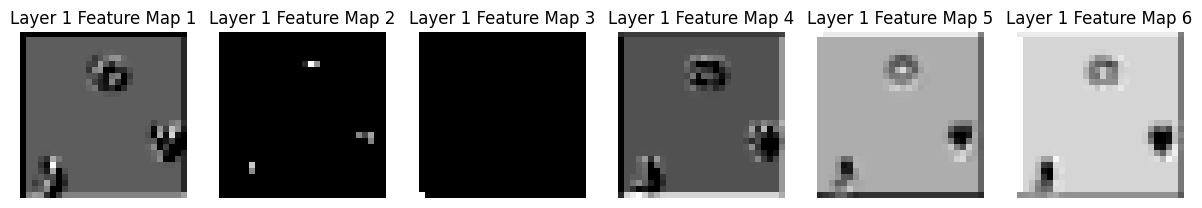

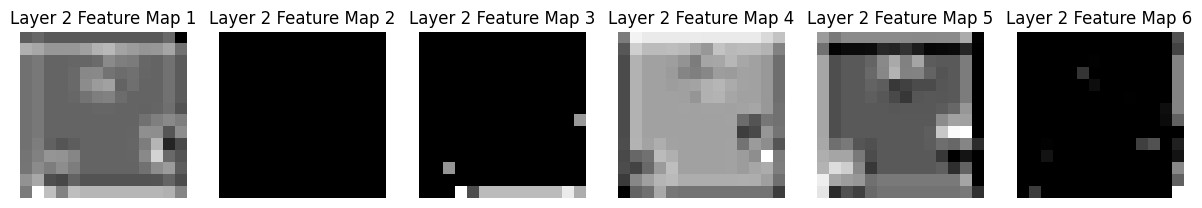

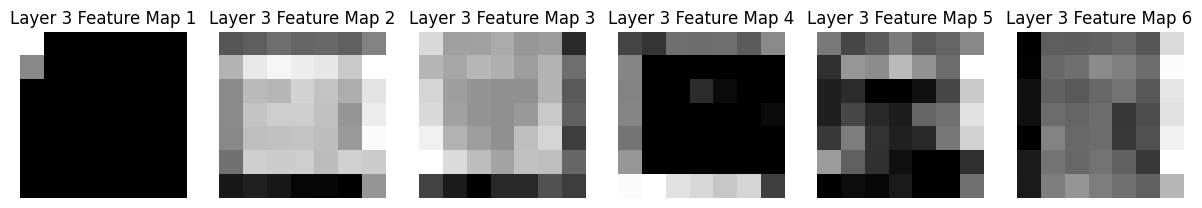

In [ ]:
class MultiMNISTCNN(nn.Module):
    def __init__(self, task="classification", dropout_rate=0.0):
        super(MultiMNISTCNN, self).__init__()
        self.task = task
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 3 * 3, 64)
        self.dropout = nn.Dropout(dropout_rate)

        if self.task == "classification":
            self.fc2 = nn.Linear(64, 4)
        elif self.task == "regression":
            self.fc2 = nn.Linear(64, 1)

        self.feature_maps = []

    def forward(self, x):
        
        self.feature_maps.clear()

        x = F.relu(self.conv1(x))
        self.feature_maps.append(x)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        self.feature_maps.append(x)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        self.feature_maps.append(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        if self.task == "classification":
            x = F.log_softmax(self.fc2(x), dim=1)
        else:
            x = self.fc2(x)

        return x


def visualize_feature_maps(model, images):
    model.eval()  
    with torch.no_grad():
        _ = model(images) 

    feature_maps = model.feature_maps

    # Plot the original image and feature maps
    for i, image in enumerate(images):
        # Display the original image
        plt.figure(figsize=(4, 4))
        plt.imshow(image[0].cpu(), cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis('off')
        plt.show()

        for layer_index, fmap in enumerate(feature_maps):
            num_feature_maps = fmap.size(1)

            plt.figure(figsize=(15, 3))
            for j in range(min(num_feature_maps, 6)):
                plt.subplot(1, 6, j + 1)
                plt.imshow(fmap[i, j].cpu(), cmap='gray') 
                plt.axis('off')
                plt.title(f"Layer {layer_index + 1} Feature Map {j + 1}")
            plt.show()


# # Load data from the dataset
# data_dir = "double_mnist/double_mnist"  # Use the extracted folder path
# (train_data, train_labels), (val_data, val_labels), (test_data, test_labels) = load_mnist_data(data_dir)

# # Convert lists to tensors
# train_data = torch.stack(train_data)
# train_labels = torch.tensor(train_labels)
# val_data = torch.stack(val_data)
# val_labels = torch.tensor(val_labels)
# test_data = torch.stack(test_data)
# test_labels = torch.tensor(test_labels)

# # Load a few test images
# test_images = test_data[:3]  # Select the first three images
# # test_images = test_images.unsqueeze(0)  # Add batch dimension if needed

# model_classification = MultiMNISTCNN(task="classification")
# # Visualize feature maps
# visualize_feature_maps(model_classification, test_images)

# Paths to specific images


image_paths = [
    "double_mnist/double_mnist/test/25/12_25.png",
    "double_mnist/double_mnist/test/014/4_014.png",
    "double_mnist/double_mnist/test/304/1_304.png"
]

import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(12, 4))  # Adjust size as needed

for i, path in enumerate(image_paths):
    img = Image.open(path)

    # Plot the image
    plt.subplot(1, len(image_paths), i + 1)  
    plt.imshow(img, cmap='gray')
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Load and preprocess the images
images = []
for path in image_paths:
    img = Image.open(path)
    img_tensor = transform(img)  
    images.append(img_tensor)


images_tensor = torch.stack(images)

model_classification = MultiMNISTCNN(task="classification")
visualize_feature_maps(model_classification, images_tensor)


Observing the feature maps, we could see that :


##### 1st layer :

it is mean filtering layer, so we could see the numbers in blurred form, atleast the digit count could be estimated. It is tring to capture the bright regions in the image.


##### 2nd and 3rd layer :

Some other importantant feature charecteristics are represented by the 2nd and 3rd layer. The digit count is not prominently determined by it.
